### Toolbox
* Graphical and quantitative EDA
* Parameter estimation
* Confidence interval calculation
* Hypothesis testing

### Study of finches on Daphne Major island (http://dx.doi.org/10.5061/dryad.g6g3h)
* Do EDA of beak depths
* Parameter estimation of mean beak depth
* Do a hypothesis test to determine if the beaks got deeper 

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

reader = pd.read_csv('finch_beaks_1975.csv', usecols=('species', 'Beak length, mm', 'Beak depth, mm'), chunksize=100)
# read only scandens's data
df_1975 = pd.concat(chunck[chunck['species'] == 'scandens'] for chunck in reader)
df_1975.rename(columns={'Beak length, mm':'length', 'Beak depth, mm':'depth'}, inplace=True)
df_1975['year'] = 1975
df_1975.head()

species  length  depth  year
316  scandens    13.9    8.4  1975
317  scandens    14.0    8.8  1975
318  scandens    12.9    8.4  1975
319  scandens    13.5    8.0  1975
320  scandens    12.9    7.9  1975

In [2]:
reader = pd.read_csv('finch_beaks_2012.csv', usecols=('species', 'blength', 'bdepth'), chunksize=100)
# read only scandens's data
df_2012 = pd.concat(chunck[chunck['species'] == 'scandens'] for chunck in reader)
df_2012.rename(columns={'blength':'length', 'bdepth':'depth'}, inplace=True)
df_2012['year'] = 2012
df_2012.head()

species  length  depth  year
121  scandens    14.3    9.4  2012
122  scandens    12.5    8.9  2012
123  scandens    13.7    9.5  2012
124  scandens    13.8   11.0  2012
125  scandens    12.0    8.7  2012

In [3]:
# df1 = df_1975[['year', 'depth']]
# df2 = df_2012[['year', 'depth']]
# df1.merge(df2, how='outer')
df = df_1975[['year', 'depth']].merge(df_2012[['year', 'depth']], how='outer')
# print(df.head(2))
# print(df.tail(2))
# df2
#df = df_1975['depth'].append(df_2012['depth'], ignore_index=True)

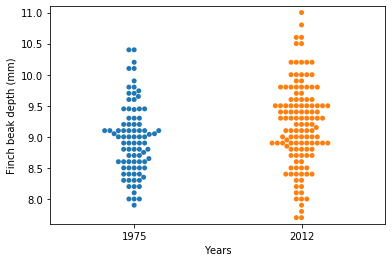

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

_ = sns.swarmplot(x='year', y='depth', data=df)
_ = plt.xlabel('Years')
_ = plt.ylabel('Finch beak depth (mm)')
_ = plt.margins(0.02)

plt.show()

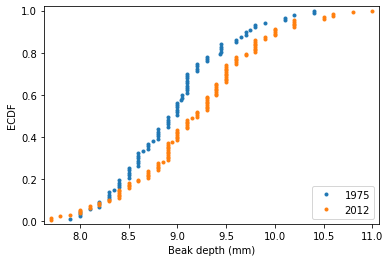

In [5]:
%run ECDF.ipynb

# Compute ECDFs
x_1975, y_1975 = compute_ecdf(df_1975['depth'])
x_2012, y_2012 = compute_ecdf(df_2012['depth'])

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
_ = plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('Beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

In [6]:
# Compute the difference of the sample means
mean_diff = np.mean(df_2012['depth']) - np.mean(df_1975['depth'])

%run draw_bs_reps.ipynb

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(df_1975['depth'], np.mean, 10_000)
bs_replicates_2012 = draw_bs_reps(df_2012['depth'], np.mean, 10_000)

# Compute samples of difference of means
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05633521 0.39190544] mm


### Hypothesis test: Are beaks deeper in 2012?

In [7]:
# Compute mean of combined data set
combined_mean = np.mean(np.concatenate((df_1975['depth'], df_2012['depth'])))

# Shift the samples
bd_1975_shifted = df_1975['depth'] - np.mean(df_1975['depth']) + combined_mean
bd_2012_shifted = df_2012['depth'] - np.mean(df_2012['depth']) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10_000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10_000)

# Compute replicates of difference of means
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0037


### EDA of beak length and depth

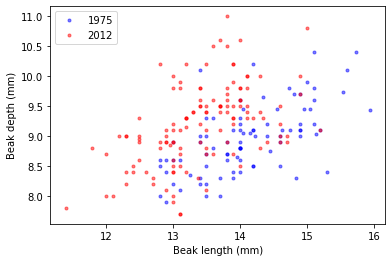

In [8]:
# Make scatter plot of 1975 data
_ = plt.plot(df_1975['length'], df_1975['depth'], marker='.', linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(df_2012['length'], df_2012['depth'], marker='.', linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Beak length (mm)')
_ = plt.ylabel('Beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

### Linear regressions
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.

In [19]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(df_1975['length'], df_1975['depth'], deg=1)
slope_2012, intercept_2012 = np.polyfit(df_2012['length'], df_2012['depth'], deg=1)

%run draw_bs_pairs_linreg.ipynb

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(df_1975['length'].values, 
                                                                  df_1975['depth'].values, 1_000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(df_2012['length'].values, 
                                                                  df_2012['depth'].values, 1_000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, (2.5, 97.5))
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, (2.5, 97.5))
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, (2.5, 97.5))
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, (2.5, 97.5))

# Print the results
print('1975: slope =', slope_1975, 'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, 'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012, 'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, 'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.32007491 0.59315739]
1975: intercept = 2.3908752365842263 conf int = [0.59325156 4.37753092]
2012: slope = 0.462630358835313 conf int = [0.33165455 0.59921525]
2012: intercept = 2.977247498236019 conf int = [1.19736755 4.76583926]


### Displaying the linear regression results

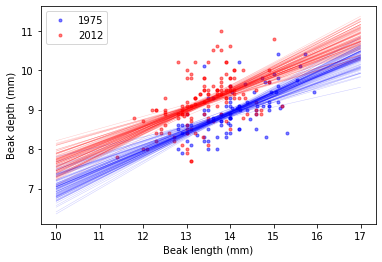

In [20]:
# Make scatter plot of 1975 data
_ = plt.plot(df_1975['length'], df_1975['depth'], marker='.', linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(df_2012['length'], df_2012['depth'], marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Beak length (mm)')
_ = plt.ylabel('Beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i], linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

### Beak length to depth ratio

In [21]:
# Compute length-to-depth ratios
ratio_1975 = df_1975['length'] / df_1975['depth']
ratio_2012 = df_2012['length'] / df_2012['depth']

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10_000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10_000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, (0.5, 99.5))
conf_int_2012 = np.percentile(bs_replicates_2012, (0.5, 99.5))

# Print the results
print('1975: mean ratio =', mean_ratio_1975, 'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012, 'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55700504 1.60057006]
2012: mean ratio = 1.4658342276847767 conf int = [1.44388756 1.48826402]
